# 1 前言
### 1.1课程回顾

<img src='imgs/synopsis.png' width="800" height="800" align="bottom">

### 1.2 模型结构
<img src="./imgs/overall_cnn_re.png"  width="700" height="700" align="bottom" />

### 1.3 代码结构展示
<img src="./imgs/structure.jpg"  width="500" height="500" align="left" />

# 2 准备工作
### 2.1项目环境配置

* Python3.8
* jupyter notebook
* torch           1.6.0+cu10.2
* numpy           1.18.5

代码运行环境建议使用Visual Studio Code(VScode)，相比于Pycharm， VScode更加方便好用


### 2.2 数据集下载
SemEval2010_task8数据集，可以在https://drive.google.com/file/d/0B_jQiLugGTAkMDQ5ZjZiMTUtMzQ1Yy00YWNmLWJlZDYtOWY1ZDMwY2U4YjFk/view?sort=name&layout=list&num=50 <br>
上下载, 同时我们课程会提供给大家

### 2.3 Word embedding下载
文件名：hlbl-embeddings-scaled.EMBEDDING_SIZE=50 <br>
链接：https://pan.baidu.com/s/1Nm1dcad7h3Y6xVQ8TK9KDw <br> 
提取码：qn5x 

# 3 项目代码结构（VScode中演示）

>1）是什么？

　　我们首先会在VScode环境中让代码跑一下，直观感受到项目的训练，并展示前向推断的输出，让大家看到模型的效果。
>2）怎么构成的？

　　然后介绍项目代码的构成，介绍项目有哪些文件夹，包含哪些文件，这些文件构成了什么功能模块如：数据预处理模块，模型设计模块，损失函数模块，推断与评估模块。
>3）小结

　　在run.py主文件中在过一下启动训练的流程。

# 4 算法模块及细节（jupyter和VScode中演示）

　　在jupyter notebook中细致地讲解每一个模块。
  
　　以实现模块功能为目的，来讲解每个函数的执行流程，并尽可能地呈现中间数据，方便同学们理解学习。
  
　　内容分为4个模块：**数据处理，模型设计，损失函数计算，模型评估**。

In [35]:
import argparse
import torch
import os
import random
import json
import numpy as np
from torch.utils.data import Dataset, DataLoader

## 4.1 超参数设置

In [5]:
class Config(object):
    def __init__(self):
        # get init config
        args = self.__get_config()
        for key in args.__dict__:
            setattr(self, key, args.__dict__[key])

        # select device
        self.device = None
        if self.cuda >= 0 and torch.cuda.is_available():
            self.device = torch.device('cuda:{}'.format(self.cuda))
        else:
            self.device = torch.device('cpu')

        # determine the model name and model dir
        if self.model_name is None:
            self.model_name = 'CNN'
        self.model_dir = os.path.join(self.output_dir, self.model_name)
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)

        # backup data
        self.__config_backup(args)

        # set the random seed
        self.__set_seed(self.seed)

    def __get_config(self):
        parser = argparse.ArgumentParser()
        parser.description = 'config for models'

        # several key selective parameters
        parser.add_argument('--data_dir', type=str,
                            default='./data',
                            help='dir to load data')
        parser.add_argument('--output_dir', type=str,
                            default='./output',
                            help='dir to save output')

        # word embedding
        parser.add_argument('--embedding_path', type=str,
                            default='./embedding/hlbl-embeddings-scaled.EMBEDDING_SIZE=50.txt',
                            help='pre_trained word embedding')
        parser.add_argument('--word_dim', type=int,
                            default=50,
                            help='dimension of word embedding')

        # train settings
        parser.add_argument('--model_name', type=str,
                            default=None,
                            help='model name')
        parser.add_argument('--mode', type=int,
                            default=1,
                            choices=[0, 1],
                            help='running mode: 1 for training; otherwise testing')
        parser.add_argument('--seed', type=int,
                            default=5782,
                            help='random seed')
        parser.add_argument('--cuda', type=int,
                            default=0,
                            help='num of gpu device, if -1, select cpu')
        parser.add_argument('--epoch', type=int,
                            default=20,
                            help='max epoches during training')

        # hyper parameters
        parser.add_argument('--dropout', type=float,
                            default=0.5,
                            help='the possiblity of dropout')
        parser.add_argument('--batch_size', type=int,
                            default=128,
                            help='batch size')
        parser.add_argument('--lr', type=float,
                            default=0.001,
                            help='learning rate')
        parser.add_argument('--max_len', type=int,
                            default=100,
                            help='max length of sentence')
        parser.add_argument('--pos_dis', type=int, default=50,
                            help='max distance of position embedding')
        parser.add_argument('--pos_dim', type=int,
                            default=5,
                            help='dimension of position embedding')
        parser.add_argument('--hidden_size', type=int, default=100,
                            help='the size of linear layer between convolution and classification')

        # hyper parameters for cnn
        parser.add_argument('--filter_num', type=int, default=200,
                            help='the number of filters in convolution')
        parser.add_argument('--window', type=int, default=3,
                            help='the size of window in convolution')

        parser.add_argument('--L2_decay', type=float, default=1e-5,
                            help='L2 weight decay')

        args = parser.parse_args(args=[])
#         args = parser.parse_args()
        return args

    def __set_seed(self, seed=1234):
        os.environ['PYTHONHASHSEED'] = '{}'.format(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)  # set seed for cpu
        torch.cuda.manual_seed(seed)  # set seed for current gpu
        torch.cuda.manual_seed_all(seed)  # set seed for all gpu

    def __config_backup(self, args):
        config_backup_path = os.path.join(self.model_dir, 'config.json')
        with open(config_backup_path, 'w', encoding='utf-8') as fw:
            json.dump(vars(args), fw, ensure_ascii=False)

    def print_config(self):
        for key in self.__dict__:
            print(key, end=' = ')
            print(self.__dict__[key])

In [6]:
config = Config()

In [7]:
config.print_config()

data_dir = ./data
output_dir = ./output
embedding_path = ./embedding/hlbl-embeddings-scaled.EMBEDDING_SIZE=50.txt
word_dim = 50
model_name = CNN
mode = 1
seed = 5782
cuda = 0
epoch = 20
dropout = 0.5
batch_size = 128
lr = 0.001
max_len = 100
pos_dis = 50
pos_dim = 5
hidden_size = 100
filter_num = 200
window = 3
L2_decay = 1e-05
device = cuda:0
model_dir = ./output/CNN


## 4.2 数据读取 
* 预训练词向量读取
* 关系标签读取

### 4.2.1 预训练词向量读取

In [8]:
class WordEmbeddingLoader(object):
    """
    A loader for pre-trained word embedding
    """

    def __init__(self, config):
        self.path_word = config.embedding_path  # path of pre-trained word embedding
        self.word_dim = config.word_dim  # dimension of word embedding

    def load_embedding(self):
        word2id = dict()  # word to wordID
        word_vec = list()  # wordID to word embedding

        word2id['PAD'] = len(word2id)  # PAD character

        with open(self.path_word, 'r', encoding='utf-8') as fr:
            for line in fr:
                line = line.strip().split()
                if len(line) != self.word_dim + 1:
                    continue
                word2id[line[0]] = len(word2id)
                word_vec.append(np.asarray(line[1:], dtype=np.float32))

        pad_emb = np.zeros([1, self.word_dim], dtype=np.float32)  # <pad> is initialize as zero
        word_vec = np.concatenate((pad_emb, word_vec), axis=0)
        word_vec = word_vec.astype(np.float32).reshape(-1, self.word_dim)
        word_vec = torch.from_numpy(word_vec)
        return word2id, word_vec

In [9]:
# 预训练词向量读取
word2id, word_vec = WordEmbeddingLoader(config).load_embedding()

In [10]:
word2id

{'PAD': 0,
 '*UNKNOWN*': 1,
 'the': 2,
 '.': 3,
 ',': 4,
 'to': 5,
 'of': 6,
 'in': 7,
 'a': 8,
 'and': 9,
 '"': 10,
 'said': 11,
 'on': 12,
 'for': 13,
 "'s": 14,
 'The': 15,
 'that': 16,
 'is': 17,
 'was': 18,
 'by': 19,
 'be': 20,
 'with': 21,
 'it': 22,
 'as': 23,
 'from': 24,
 'at': 25,
 'will': 26,
 'has': 27,
 'not': 28,
 'would': 29,
 'have': 30,
 'its': 31,
 'he': 32,
 'are': 33,
 'an': 34,
 'had': 35,
 'were': 36,
 'which': 37,
 'but': 38,
 'market': 39,
 'percent': 40,
 'this': 41,
 'been': 42,
 'year': 43,
 'government': 44,
 'their': 45,
 'after': 46,
 'his': 47,
 'they': 48,
 'also': 49,
 'company': 50,
 'up': 51,
 'one': 52,
 'more': 53,
 'who': 54,
 ')': 55,
 '(': 56,
 'new': 57,
 'two': 58,
 'over': 59,
 'million': 60,
 'or': 61,
 'last': 62,
 'about': 63,
 'could': 64,
 'we': 65,
 'some': 66,
 'But': 67,
 'than': 68,
 'It': 69,
 'into': 70,
 'first': 71,
 '--': 72,
 'other': 73,
 'told': 74,
 'out': 75,
 'no': 76,
 'week': 77,
 'there': 78,
 'expected': 79,
 'He': 80,

In [15]:
word_vec.shape

torch.Size([246123, 50])

### 4.2.2 关系标签读取

In [16]:
class RelationLoader(object):
    def __init__(self, config):
        self.data_dir = config.data_dir

    def __load_relation(self):
        relation_file = os.path.join(self.data_dir, 'relation2id.txt')
        rel2id = {}
        id2rel = {}
        with open(relation_file, 'r', encoding='utf-8') as fr:
            for line in fr:
                relation, id_s = line.strip().split()
                id_d = int(id_s)
                rel2id[relation] = id_d
                id2rel[id_d] = relation
        return rel2id, id2rel, len(rel2id)

    def get_relation(self):
        return self.__load_relation()

In [22]:
f_rel2id = open(os.path.join(config.data_dir, 'relation2id.txt'), 'r')

In [24]:
f_rel2id.readlines()

['Cause-Effect(e1,e2)\t1\n',
 'Cause-Effect(e2,e1)\t2\n',
 'Component-Whole(e1,e2)\t3\n',
 'Component-Whole(e2,e1)\t4\n',
 'Content-Container(e1,e2)\t5\n',
 'Content-Container(e2,e1)\t6\n',
 'Entity-Destination(e1,e2)\t7\n',
 'Entity-Destination(e2,e1)\t8\n',
 'Entity-Origin(e1,e2)\t9\n',
 'Entity-Origin(e2,e1)\t10\n',
 'Instrument-Agency(e1,e2)\t11\n',
 'Instrument-Agency(e2,e1)\t12\n',
 'Member-Collection(e1,e2)\t13\n',
 'Member-Collection(e2,e1)\t14\n',
 'Message-Topic(e1,e2)\t15\n',
 'Message-Topic(e2,e1)\t16\n',
 'Product-Producer(e1,e2)\t17\n',
 'Product-Producer(e2,e1)\t18\n']

In [17]:
rel2id, id2rel, class_num = RelationLoader(config).get_relation()

In [25]:
rel2id

{'Other': 0,
 'Cause-Effect(e1,e2)': 1,
 'Cause-Effect(e2,e1)': 2,
 'Component-Whole(e1,e2)': 3,
 'Component-Whole(e2,e1)': 4,
 'Content-Container(e1,e2)': 5,
 'Content-Container(e2,e1)': 6,
 'Entity-Destination(e1,e2)': 7,
 'Entity-Destination(e2,e1)': 8,
 'Entity-Origin(e1,e2)': 9,
 'Entity-Origin(e2,e1)': 10,
 'Instrument-Agency(e1,e2)': 11,
 'Instrument-Agency(e2,e1)': 12,
 'Member-Collection(e1,e2)': 13,
 'Member-Collection(e2,e1)': 14,
 'Message-Topic(e1,e2)': 15,
 'Message-Topic(e2,e1)': 16,
 'Product-Producer(e1,e2)': 17,
 'Product-Producer(e2,e1)': 18}

In [28]:
id2rel

{0: 'Other',
 1: 'Cause-Effect(e1,e2)',
 2: 'Cause-Effect(e2,e1)',
 3: 'Component-Whole(e1,e2)',
 4: 'Component-Whole(e2,e1)',
 5: 'Content-Container(e1,e2)',
 6: 'Content-Container(e2,e1)',
 7: 'Entity-Destination(e1,e2)',
 8: 'Entity-Destination(e2,e1)',
 9: 'Entity-Origin(e1,e2)',
 10: 'Entity-Origin(e2,e1)',
 11: 'Instrument-Agency(e1,e2)',
 12: 'Instrument-Agency(e2,e1)',
 13: 'Member-Collection(e1,e2)',
 14: 'Member-Collection(e2,e1)',
 15: 'Message-Topic(e1,e2)',
 16: 'Message-Topic(e2,e1)',
 17: 'Product-Producer(e1,e2)',
 18: 'Product-Producer(e2,e1)'}

In [29]:
class_num

19

## 4.3 数据预处理
* 获取原始数据
* 处理为输入数据
* 将上述方式构建为类

### 4.3.1 获取原始数据

In [69]:
f_train = open(config.data_dir + '/train.json', 'r', encoding='utf-8')

In [70]:
train_raw = []
for line in f_train:
    train_raw += [json.loads(line.strip())]

In [73]:
len(train_raw)

8000

In [76]:
train_raw[0].keys()

dict_keys(['id', 'relation', 'head', 'tail', 'subj_start', 'subj_end', 'obj_start', 'obj_end', 'sentence', 'comment'])

In [75]:
train_raw[0]

{'id': '1',
 'relation': 'Component-Whole(e2,e1)',
 'head': 'configuration',
 'tail': 'elements',
 'subj_start': 12,
 'subj_end': 12,
 'obj_start': 15,
 'obj_end': 15,
 'sentence': ['The',
  'system',
  'as',
  'described',
  'above',
  'has',
  'its',
  'greatest',
  'application',
  'in',
  'an',
  'arrayed',
  'configuration',
  'of',
  'antenna',
  'elements',
  '.'],
 'comment': ' Not a collection: there is structure here, organisation.'}

In [77]:
train_raw[0].keys()

dict_keys(['id', 'relation', 'head', 'tail', 'subj_start', 'subj_end', 'obj_start', 'obj_end', 'sentence', 'comment'])

In [79]:
line = train_raw[0]

In [80]:
label = line['relation']
sentence = line['sentence']
e1_pos = (line['subj_start'], line['subj_end'])
e2_pos = (line['obj_start'], line['obj_end'])
label_idx = rel2id[label]

In [82]:
label

'Component-Whole(e2,e1)'

In [85]:
label_idx

4

### 4.3.2  处理为输入数据 （处理为输入数据）

In [86]:
mask = [1] * len(sentence)

In [87]:
mask

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [90]:
e1_pos

(12, 12)

In [91]:
e2_pos

(15, 15)

In [88]:
if e1_pos[0] < e2_pos[0]:
    for i in range(e1_pos[0], e2_pos[1]+1):
        mask[i] = 2
    for i in range(e2_pos[1]+1, len(sentence)):
        mask[i] = 3
else:
    for i in range(e2_pos[0], e1_pos[1]+1):
        mask[i] = 2
    for i in range(e1_pos[1]+1, len(sentence)):
        mask[i] = 3

In [89]:
mask

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3]

In [128]:
words = []
pos1 = []
pos2 = []
length = min(config.max_len, len(sentence))
mask = mask[:length]

In [95]:
config.max_len

100

In [96]:
len(sentence)

17

In [108]:
words.append(word2id.get(sentence[0].lower(), word2id['*UNKNOWN*']))

In [109]:
words

[2]

In [110]:
config.pos_dis

50

In [116]:
def __get_pos_index(x):
    if x < -config.pos_dis:
        return 0
    if x >= -config.pos_dis and x <= config.pos_dis:
        return x + config.pos_dis + 1
    if x > config.pos_dis:
        return 2 * config.pos_dis + 2

In [117]:
def __get_relative_pos(x, entity_pos):
    if x < entity_pos[0]:
        return __get_pos_index(x-entity_pos[0])
    elif x > entity_pos[1]:
        return __get_pos_index(x-entity_pos[1])
    else:
        return __get_pos_index(0)

In [118]:
e1_pos

(12, 12)

In [125]:
pos1.append(__get_relative_pos(14, e1_pos))
pos1

[39, 39, 51, 53]

In [127]:
pos2.append(__get_relative_pos(0, e2_pos))
pos2

[36, 36]

In [130]:
# 对整个句子进行处理
for i in range(length):
    words.append(word2id.get(sentence[i].lower(), word2id['*UNKNOWN*']))
    pos1.append(__get_relative_pos(i, e1_pos))
    pos2.append(__get_relative_pos(i, e2_pos))

In [132]:
pos1

[39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]

In [134]:
# padding
if length < config.max_len:
    for i in range(length, config.max_len):
        mask.append(0)  # 'PAD' mask is zero
        words.append(word2id['PAD'])

        pos1.append(__get_relative_pos(i, e1_pos))
        pos2.append(__get_relative_pos(i, e2_pos))

In [137]:
len(words)

100

In [138]:
unit = np.asarray([words, pos1, pos2, mask], dtype=np.int64)
unit

array([[    2,   249,    23,  1615,   797,    27,    31,  4434,  2695,
            7,    34, 70021, 20173,     6, 41589,  3813,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [   39,    40,    41,    42,    43,    44,    45,    46,    47,
           48,    49,    50,    51,    52,    53,    54,    55,    56,
           57,    58,    59,    60,    61,    62,    63,    6

In [139]:
unit.shape

(4, 100)

In [141]:
unit = np.reshape(unit, newshape=(1, 4, config.max_len))
unit.shape

(1, 4, 100)

### 4.3.3 将上述功能构建为类
* 将相似类型的功能整合到一个类里，使代码结构更清晰，并且方面以后调佣，且有利于debug

<img src="./imgs/data_loader_flow_1.png"  width="700" height="700" align="bottom" />

In [142]:
class SemEvalDateset(Dataset):
    def __init__(self, filename, rel2id, word2id, config):
        self.filename = filename
        self.rel2id = rel2id
        self.word2id = word2id
        self.max_len = config.max_len
        self.pos_dis = config.pos_dis
        self.data_dir = config.data_dir
        self.dataset, self.label = self.__load_data()

    def __get_pos_index(self, x):
        if x < -self.pos_dis:
            return 0
        if x >= -self.pos_dis and x <= self.pos_dis:
            return x + self.pos_dis + 1
        if x > self.pos_dis:
            return 2 * self.pos_dis + 2

    def __get_relative_pos(self, x, entity_pos):
        if x < entity_pos[0]:
            return self.__get_pos_index(x-entity_pos[0])
        elif x > entity_pos[1]:
            return self.__get_pos_index(x-entity_pos[1])
        else:
            return self.__get_pos_index(0)

    def __symbolize_sentence(self, e1_pos, e2_pos, sentence):
        """
            Args:
                e1_pos (tuple) span of e1
                e2_pos (tuple) span of e2
                sentence (list)
        """
        mask = [1] * len(sentence)
        if e1_pos[0] < e2_pos[0]:
            for i in range(e1_pos[0], e2_pos[1]+1):
                mask[i] = 2
            for i in range(e2_pos[1]+1, len(sentence)):
                mask[i] = 3
        else:
            for i in range(e2_pos[0], e1_pos[1]+1):
                mask[i] = 2
            for i in range(e1_pos[1]+1, len(sentence)):
                mask[i] = 3

        words = []
        pos1 = []
        pos2 = []
        length = min(self.max_len, len(sentence))
        mask = mask[:length]

        for i in range(length):
            words.append(self.word2id.get(sentence[i].lower(), self.word2id['*UNKNOWN*']))
            pos1.append(self.__get_relative_pos(i, e1_pos))
            pos2.append(self.__get_relative_pos(i, e2_pos))

        if length < self.max_len:
            for i in range(length, self.max_len):
                mask.append(0)  # 'PAD' mask is zero
                words.append(self.word2id['PAD'])

                pos1.append(self.__get_relative_pos(i, e1_pos))
                pos2.append(self.__get_relative_pos(i, e2_pos))
        unit = np.asarray([words, pos1, pos2, mask], dtype=np.int64)
        unit = np.reshape(unit, newshape=(1, 4, self.max_len))
        return unit

    def __load_data(self):
        path_data_file = os.path.join(self.data_dir, self.filename)
        data = []
        labels = []
        with open(path_data_file, 'r', encoding='utf-8') as fr:
            for line in fr:
                line = json.loads(line.strip())
                label = line['relation']
                sentence = line['sentence']
                e1_pos = (line['subj_start'], line['subj_end'])
                e2_pos = (line['obj_start'], line['obj_end'])
                label_idx = self.rel2id[label]

                one_sentence = self.__symbolize_sentence(e1_pos, e2_pos, sentence)
                data.append(one_sentence)
                labels.append(label_idx)
        return data, labels

    def __getitem__(self, index):
        data = self.dataset[index]
        label = self.label[index]
        return data, label

    def __len__(self):
        return len(self.label)

In [144]:
class SemEvalDataLoader(object):
    def __init__(self, rel2id, word2id, config):
        self.rel2id = rel2id
        self.word2id = word2id
        self.config = config

    def __collate_fn(self, batch):
        data, label = zip(*batch)  # unzip the batch data
        data = list(data)
        label = list(label)
        data = torch.from_numpy(np.concatenate(data, axis=0))
        label = torch.from_numpy(np.asarray(label, dtype=np.int64))
        return data, label

    def __get_data(self, filename, shuffle=False):
        dataset = SemEvalDateset(filename, self.rel2id, self.word2id, self.config)
        loader = DataLoader(
            dataset=dataset,
            batch_size=self.config.batch_size,
            shuffle=shuffle,
            num_workers=2,    # num_workers 多进程处理数据 0 表示不使用多进程
            collate_fn=self.__collate_fn  # 该函数将batch_size个样本合并成一个batch
        )
        return loader

    def get_train(self):
        return self.__get_data('train.json', shuffle=True)

    def get_dev(self):
        return self.__get_data('test.json', shuffle=False)

    def get_test(self):
        return self.__get_data('test.json', shuffle=False)

In [145]:
loader = SemEvalDataLoader(rel2id, word2id, config)

train_loader, dev_loader = None, None
if config.mode == 1:  # train mode
    train_loader = loader.get_train()
    dev_loader = loader.get_dev()
test_loader = loader.get_test()
loader = [train_loader, dev_loader, test_loader]

In [146]:
train_data = [item for item in train_loader]

In [147]:
len(train_data)

63

In [149]:
train_data[0]

(tensor([[[    2,  3588,  4340,  ...,     0,     0,     0],
          [   49,    50,    51,  ...,   102,   102,   102],
          [   45,    46,    47,  ...,   102,   102,   102],
          [    1,     1,     2,  ...,     0,     0,     0]],
 
         [[    2,   352,  1878,  ...,     0,     0,     0],
          [   46,    47,    48,  ...,   102,   102,   102],
          [   43,    44,    45,  ...,   102,   102,   102],
          [    1,     1,     1,  ...,     0,     0,     0]],
 
         [[53981,   347, 52619,  ...,     0,     0,     0],
          [   51,    52,    53,  ...,   102,   102,   102],
          [   49,    50,    51,  ...,   102,   102,   102],
          [    2,     2,     2,  ...,     0,     0,     0]],
 
         ...,
 
         [[89333,     1, 12212,  ...,     0,     0,     0],
          [   41,    42,    43,  ...,   102,   102,   102],
          [   38,    39,    40,  ...,   102,   102,   102],
          [    1,     1,     1,  ...,     0,     0,     0]],
 
         [[ 

In [150]:
train_data[0][1].shape

torch.Size([128])

In [151]:
train_data[0][0].shape

torch.Size([128, 4, 100])

## 4.4 模型训练

In [163]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim

In [154]:
# 定义模型
class CNN(nn.Module):
    def __init__(self, word_vec, class_num, config):
        super().__init__()
        self.word_vec = word_vec
        self.class_num = class_num

        # hyper parameters and others
        self.max_len = config.max_len
        self.word_dim = config.word_dim
        self.pos_dim = config.pos_dim
        self.pos_dis = config.pos_dis

        self.dropout_value = config.dropout
        self.filter_num = config.filter_num
        self.window = config.window
        self.hidden_size = config.hidden_size

        self.dim = self.word_dim + 2 * self.pos_dim

        # net structures and operations
        self.word_embedding = nn.Embedding.from_pretrained(
            embeddings=self.word_vec,
            freeze=False,
        )
        self.pos1_embedding = nn.Embedding(
            num_embeddings=2 * self.pos_dis + 3,
            embedding_dim=self.pos_dim
        )
        self.pos2_embedding = nn.Embedding(
            num_embeddings=2 * self.pos_dis + 3,
            embedding_dim=self.pos_dim
        )

        self.conv = nn.Conv2d(
            in_channels=1,
            out_channels=self.filter_num,
            kernel_size=(self.window, self.dim),
            stride=(1, 1),
            bias=True,
            padding=(1, 0),  # same padding
            padding_mode='zeros'
        )
        self.maxpool = nn.MaxPool2d((self.max_len, 1))
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(self.dropout_value)
        self.linear = nn.Linear(
            in_features=self.filter_num,
            out_features=self.hidden_size,
            bias=True
        )
        self.dense = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.class_num,
            bias=True
        )

        # initialize weight
        init.xavier_normal_(self.pos1_embedding.weight)
        init.xavier_normal_(self.pos2_embedding.weight)
        init.xavier_normal_(self.conv.weight)
        init.constant_(self.conv.bias, 0.)
        init.xavier_normal_(self.linear.weight)
        init.constant_(self.linear.bias, 0.)
        init.xavier_normal_(self.dense.weight)
        init.constant_(self.dense.bias, 0.)

    def encoder_layer(self, token, pos1, pos2):
        word_emb = self.word_embedding(token)  # B*L*word_dim
        pos1_emb = self.pos1_embedding(pos1)  # B*L*pos_dim
        pos2_emb = self.pos2_embedding(pos2)  # B*L*pos_dim
        emb = torch.cat(tensors=[word_emb, pos1_emb, pos2_emb], dim=-1)
        return emb  # B*L*D, D=word_dim+2*pos_dim

    def conv_layer(self, emb, mask):
        emb = emb.unsqueeze(dim=1)  # B*1*L*D
        conv = self.conv(emb)  # B*C*L*1

        # mask, remove the effect of 'PAD'
        conv = conv.view(-1, self.filter_num, self.max_len)  # B*C*L
        mask = mask.unsqueeze(dim=1)  # B*1*L
        mask = mask.expand(-1, self.filter_num, -1)  # B*C*L
        conv = conv.masked_fill_(mask.eq(0), float('-inf'))  # B*C*L
        conv = conv.unsqueeze(dim=-1)  # B*C*L*1
        return conv

    def single_maxpool_layer(self, conv):
        pool = self.maxpool(conv)  # B*C*1*1
        pool = pool.view(-1, self.filter_num)  # B*C
        return pool

    def forward(self, data):
        token = data[:, 0, :].view(-1, self.max_len)
        pos1 = data[:, 1, :].view(-1, self.max_len)
        pos2 = data[:, 2, :].view(-1, self.max_len)
        mask = data[:, 3, :].view(-1, self.max_len)
        emb = self.encoder_layer(token, pos1, pos2)
        emb = self.dropout(emb)
        conv = self.conv_layer(emb, mask)
        pool = self.single_maxpool_layer(conv)
        sentence_feature = self.linear(pool)
        sentence_feature = self.tanh(sentence_feature)
        sentence_feature = self.dropout(sentence_feature)
        logits = self.dense(sentence_feature)
        return logits

In [156]:
# 实例化
model = CNN(word_vec=word_vec, class_num=class_num, config=config)
model

CNN(
  (word_embedding): Embedding(246123, 50)
  (pos1_embedding): Embedding(103, 5)
  (pos2_embedding): Embedding(103, 5)
  (conv): Conv2d(1, 200, kernel_size=(3, 60), stride=(1, 1), padding=(1, 0))
  (maxpool): MaxPool2d(kernel_size=(100, 1), stride=(100, 1), padding=0, dilation=1, ceil_mode=False)
  (tanh): Tanh()
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=200, out_features=100, bias=True)
  (dense): Linear(in_features=100, out_features=19, bias=True)
)

In [159]:
model = model.to(config.device)

In [160]:
# 定义loss
criterion = nn.CrossEntropyLoss()

In [161]:
# 训练模型
# train(model, criterion, loader, config)
train_loader, dev_loader, _ = loader

In [164]:
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=config.lr,
                           weight_decay=config.L2_decay)

In [206]:
data, label = list(train_loader)[1]

In [207]:
data

tensor([[[16351,  1658,     2,  ...,     0,     0,     0],
         [   48,    49,    50,  ...,   102,   102,   102],
         [   44,    45,    46,  ...,   102,   102,   102],
         [    1,     1,     1,  ...,     0,     0,     0]],

        [[   22,  6225,     8,  ...,     0,     0,     0],
         [   48,    49,    50,  ...,   102,   102,   102],
         [   42,    43,    44,  ...,   102,   102,   102],
         [    1,     1,     1,  ...,     0,     0,     0]],

        [[    7,     8,  5252,  ...,     0,     0,     0],
         [   41,    42,    43,  ...,   102,   102,   102],
         [   32,    33,    34,  ...,   102,   102,   102],
         [    1,     1,     1,  ...,     0,     0,     0]],

        ...,

        [[   22,    17,    34,  ...,     0,     0,     0],
         [   47,    48,    49,  ...,   102,   102,   102],
         [   45,    46,    47,  ...,   102,   102,   102],
         [    1,     1,     1,  ...,     0,     0,     0]],

        [[    2,     1,     1,  ..

In [208]:
# 将模型切换为训练模式，并且将数据放在cuda上
model.train()
data = data.to(config.device)
label = label.to(config.device)

In [209]:
# 在跑当前batch之前，将梯度置0，上一个batch的梯度已经更新过了，即告诉模型不要再管上一个batch的梯度了，不清零会累加计算。
# 也可以多个batch只调用一次optimizer.zero_grad()函数，这样相当于增大了batch_size
optimizer.zero_grad()  

In [210]:
# 将数据送入模型计算，此处的细节看VScode断点调试
logits = model(data)

In [211]:
logits.shape

torch.Size([128, 19])

In [212]:
loss = criterion(logits, label)
loss

tensor(2.9072, device='cuda:0', grad_fn=<NllLossBackward>)

In [213]:
# 梯度方向传播，根据loss计算每个参数的梯度
loss.backward()

In [214]:
# 通过梯度下降算法来更新参数的值
optimizer.step()

In [215]:
list(model.dense.named_parameters())

[('weight',
  Parameter containing:
  tensor([[ 0.2550,  0.0468, -0.1352,  ..., -0.0624, -0.0360,  0.0641],
          [ 0.0474, -0.0068,  0.2009,  ..., -0.2657,  0.2465,  0.0497],
          [-0.1949, -0.0198,  0.1478,  ...,  0.0678,  0.2272, -0.1991],
          ...,
          [-0.1813,  0.0697,  0.1112,  ...,  0.0311, -0.0302, -0.0829],
          [ 0.0717, -0.4372, -0.0708,  ...,  0.2782, -0.0987,  0.0152],
          [-0.1340,  0.0910, -0.0305,  ...,  0.0989,  0.0351,  0.2546]],
         device='cuda:0', requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([ 0.0020, -0.0020,  0.0020, -0.0003,  0.0020, -0.0020, -0.0020,  0.0019,
          -0.0020, -0.0020, -0.0020, -0.0020, -0.0020, -0.0020, -0.0017,  0.0020,
          -0.0020, -0.0019, -0.0011], device='cuda:0', requires_grad=True))]

In [204]:
list(model.dense.named_parameters())

[('weight',
  Parameter containing:
  tensor([[ 0.2544,  0.0478, -0.1343,  ..., -0.0615, -0.0350,  0.0633],
          [ 0.0482, -0.0075,  0.2011,  ..., -0.2665,  0.2456,  0.0506],
          [-0.1958, -0.0189,  0.1488,  ...,  0.0688,  0.2282, -0.1998],
          ...,
          [-0.1805,  0.0687,  0.1103,  ...,  0.0302, -0.0312, -0.0819],
          [ 0.0708, -0.4382, -0.0718,  ...,  0.2789, -0.0997,  0.0159],
          [-0.1335,  0.0906, -0.0314,  ...,  0.0993,  0.0341,  0.2546]],
         device='cuda:0', requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([ 0.0010, -0.0010,  0.0010, -0.0010,  0.0010, -0.0010, -0.0010,  0.0010,
          -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010, -0.0010,  0.0010,
          -0.0010, -0.0010, -0.0010], device='cuda:0', requires_grad=True))]

## 4.5 模型评价
现在假设训练好了一个模型（或者模型训练了一个epoch），我们想看看模型现在的性能，那么就需要对模型进行评价

**目录**
* 模型预测
* 计算评价指标


### 4.5.1 模型预测

In [217]:
# 我们拿验证集的数据对模型进行评价
dev_data, dev_lb = list(dev_loader)[0]

In [219]:
dev_data.shape

torch.Size([128, 4, 100])

In [220]:
model.eval()

CNN(
  (word_embedding): Embedding(246123, 50)
  (pos1_embedding): Embedding(103, 5)
  (pos2_embedding): Embedding(103, 5)
  (conv): Conv2d(1, 200, kernel_size=(3, 60), stride=(1, 1), padding=(1, 0))
  (maxpool): MaxPool2d(kernel_size=(100, 1), stride=(100, 1), padding=0, dilation=1, ceil_mode=False)
  (tanh): Tanh()
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=200, out_features=100, bias=True)
  (dense): Linear(in_features=100, out_features=19, bias=True)
)

In [222]:
with torch.no_grad():
    dev_data = dev_data.to(config.device)
    dev_lb = dev_lb.to(config.device)

In [223]:
logits = model(dev_data)

In [225]:
logits.shape

torch.Size([128, 19])

In [226]:
loss = criterion(logits, dev_lb)
loss

tensor(2.8869, device='cuda:0', grad_fn=<NllLossBackward>)

In [227]:
_, pred = torch.max(logits, dim=1)
pred

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 7], device='cuda:0')

### 4.5.2 计算评价指标
* 然后有了预测和标签，我们就可以计算我们的指标了，本篇文章的评价指标用的是macro-averaged F1-scores

####  混淆矩阵

　　统计分类模型的分类结果，即：统计`正确归类`和`错误归类`的`样本的个数`，然后把结果放在一个表里展示出来，这个表就是混淆矩阵。
  
　　例如：宠物店有12只动物，其中`6只狗，6只猫（真实值）`，现有一个模型将这12只动物进行分类，分类预测结果为`7只狗，5只猫（预测值）`，对分类结果画出对应混淆矩阵（两行两列）进行分析（狗：类别1，猫：类别2）：

<img src="./imgs/confusion.png" width="450" height="450" align="center"/>

　　矩阵中每一项$N_{ij}$表示`样本数`,其中的`i`表示真实类别，`j`表示预测类别，如：$N_{11}=5$  表示真实为`狗`,预测是`狗`的`样本数量是5`，$N_{12}=1$  表示真实为`狗`,预测是`猫`的`样本数量为1`。 显然对`角线上的项`表示`正确分类的样本数`。
  


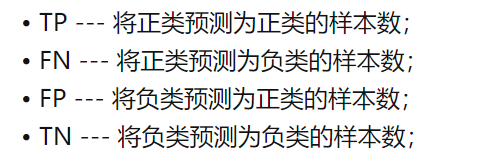

#### precision 计算方式
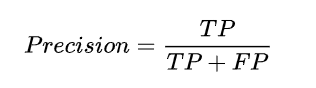

#### recall 计算方式
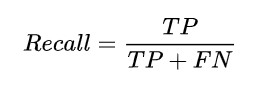

#### F1 值计算方式
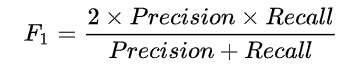

In [237]:
predict_label = pred
predict_label

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 7], device='cuda:0')

In [240]:
predict_label[0] = 15
predict_label[1] = 18
predict_label[2] = 12
predict_label[3] = 7
predict_label[4] = 2
predict_label[5] = 3

In [241]:
predict_label

tensor([15, 18, 12,  7,  2,  3,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  7], device='cuda:0')

In [244]:
true_label = dev_lb
true_label

tensor([15, 18, 12,  7,  2,  3, 17, 14,  3, 15,  7,  0,  7, 17,  9,  9,  7,  0,
        14, 17, 15,  5, 17,  0, 10, 17,  2,  0,  0,  9,  1, 15,  3, 17,  3,  4,
        14,  6, 14, 17,  1,  4,  1,  7,  9,  5,  0,  7, 15,  0,  7,  0, 14,  0,
         1,  9,  0,  1,  0,  4, 10, 17, 12,  3,  7, 18,  0,  0, 15, 17,  0,  9,
         2,  9,  0, 17,  0, 12,  7, 18,  3,  3,  1,  3, 15, 12, 15, 18, 10, 15,
         9,  0,  3,  3,  0,  7, 15,  3,  7, 15, 15,  4,  9, 15,  2,  0,  2,  1,
         4, 14,  0,  5,  0, 18,  0,  2, 17,  1, 14,  4,  7, 12,  0,  0, 15, 10,
        10,  0], device='cuda:0')

In [234]:
# 为了方便计算定义一个混淆举证
confusion_matrix = np.zeros(shape=[class_num, class_num], dtype=np.float32)
confusion_matrix.shape

(19, 19)

In [250]:
# 一共有128个样本（我们只取出一个batch的数据进行计算，batch_size=128）
# 先取出第0个样本
true_idx = true_label[0]
predict_idx = predict_label[0]
if true_label[0] == predict_label[0]:
    confusion_matrix[true_idx][true_idx] += 1

In [251]:
confusion_matrix

array([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.

In [254]:
# 遍历所有的样本数据，来构建混淆矩阵
for i in range(true_label.shape[0]):
    true_idx = true_label[i]
    predict_idx = predict_label[i]
    confusion_matrix[true_idx][predict_idx] += 1

In [255]:
confusion_matrix

array([[27.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 8.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [10.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 6.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [10.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.

In [259]:
col_sum = np.sum(confusion_matrix, axis=0).reshape(-1)
col_sum

array([123.,   2.,   3.,   3.,   2.,   2.,   1.,   4.,   1.,   1.,   2.,
         2.,   2.,   1.,   1.,   4.,   1.,   2.,   2.], dtype=float32)

In [260]:
row_sum = np.sum(confusion_matrix, axis=1).reshape(-1)
row_sum

array([28., 10.,  8., 13.,  8.,  5.,  2., 13.,  1., 10.,  7.,  2.,  6.,
        1.,  8., 17.,  1., 13.,  6.], dtype=float32)

In [258]:
f1 = np.zeros(shape=[class_num], dtype=np.float32)

In [261]:
# 计算第0个类别的f1值
p = float(confusion_matrix[0][0]) / float(col_sum[0])
r = float(confusion_matrix[0][0]) / float(row_sum[0])
f1[0] = (2 * p * r / (p + r))

In [262]:
f1

array([0.3576159, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       ], dtype=float32)

In [265]:
# 计算所有类别的f1值
for i in range(0, class_num):
    p = float(confusion_matrix[i][i]) / float(col_sum[i])
    r = float(confusion_matrix[i][i]) / float(row_sum[i])
    f1[i] = (2 * p * r / (p + r))

In [272]:
f1

array([0.3576159 , 0.33333334, 0.54545456, 0.375     , 0.4       ,
       0.5714286 , 0.6666667 , 0.3529412 , 1.        , 0.18181819,
       0.44444445, 1.        , 0.5       , 1.        , 0.22222222,
       0.3809524 , 1.        , 0.26666668, 0.5       ], dtype=float32)

In [278]:
actual_class = 0
total_f1 = 0.0

In [279]:
for i in range(1, class_num):
    if f1[i] > 0.0:  # classes that not in the predict label are not considered
        actual_class += 1
        total_f1 += f1[i]

In [280]:
macro_f1 = total_f1 / actual_class

In [281]:
macro_f1

0.5411626837319798

# 5 代码梳理及细节回顾(在VScode中演示)

　　在VScode环境中的训练文件里再回顾训练流程。

# 6 作业
  
`【思考题】`思考这篇文章中使用的CNN捕获了什么样的特征，有什么不足的地方有待改进。

`【代码实践】`复现该文章代码的模型（CNN）部分

`【画图】`按照自己的理解画出模型的结构图。

`【总结】`对这篇文章进行回顾，画出文章整体的结构图。

---